In [1]:
hbb = "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"
pr39 = "METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR"

In [2]:
from disassembly.simulate_proteolysis import simulate_proteolysis, enzyme_set, enzyme

enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1, 1, 1], #activities
    [1, 1, 1], #abundances
)


sequence_dict, sequence_graph = simulate_proteolysis(
    pr39,
    n_start=1000,
    n_iterations=2000,
    endo_or_exo_probability=[0.5, 0.5],
    enzymes=enzymes,
)

In [3]:
sequence_graph.edges(data=True)

OutEdgeDataView([('METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR', 'METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFK', {'n': 1}), ('METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR', 'ENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR', {'n': 1}), ('METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR', 'ETQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR', {'n': 1}), ('METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQ

(array([83., 84., 82., 67., 53., 58., 35., 41., 24., 29.]),
 array([  0. ,  17.2,  34.4,  51.6,  68.8,  86. , 103.2, 120.4, 137.6,
        154.8, 172. ]),
 <BarContainer object of 10 artists>)

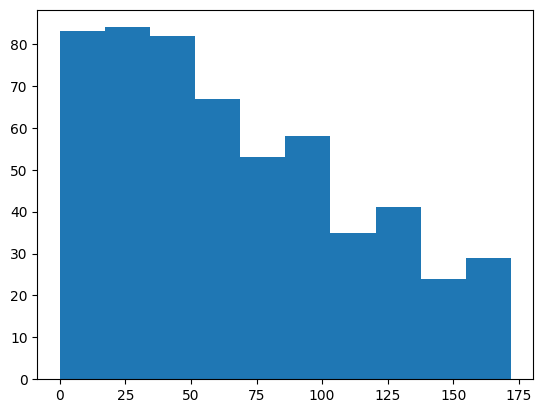

In [4]:
import matplotlib.pyplot as plt

plt.hist([len(s) for s in sequence_dict.keys()])

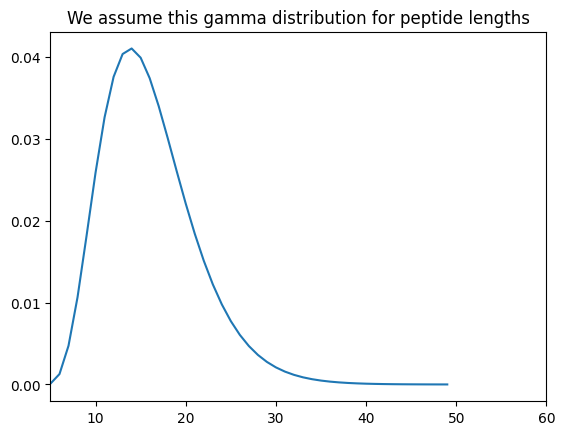

In [5]:
import numpy as np
from scipy.stats import gamma

a, shape, scale = 5.5, 8, 4.5  # mean = 8, sd = 2
g = gamma(a=a, scale=scale, loc=shape)
x = np.linspace(0, 100)
s = g.pdf(x)
plt.plot(s)
plt.xlim([5, 60])
plt.title("We assume this gamma distribution for peptide lengths")
plt.show()

In [6]:
sampled_sequence_dict = {}
sum_gamma = sum(s)
for sequence, copy_number in sequence_dict.items():
    sequence_length = len(sequence)
    a = g.pdf(sequence_length) / max(s)
    u = np.random.uniform(0, 1)
    if u < a:
        sampled_sequence_dict[sequence] = copy_number

Text(0.5, 0, 'Sequence length')

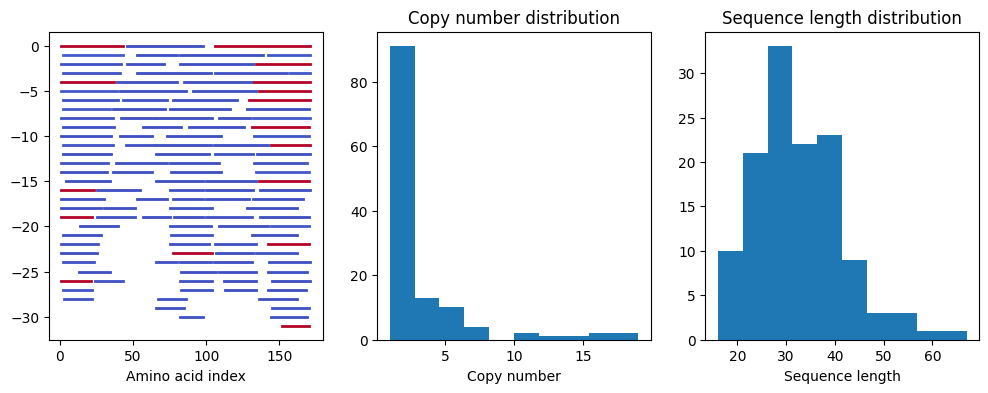

In [7]:
import numpy as np
import matplotlib

spaces = np.zeros(((len(sampled_sequence_dict.keys())), len(pr39)))

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
i = 0
cmap = matplotlib.cm.coolwarm
sampled_sequence_dict = dict(
    sorted(sampled_sequence_dict.items(), key=lambda item: len(item[0]), reverse=True)
)
for sequence, copy_number in sampled_sequence_dict.items():
    start = pr39.find(sequence)
    end = start + len(sequence)
    for height in range(spaces.shape[0]):
        position = spaces[height, start:end]
        if sum(position) == 0:
            spaces[height, start:end] = 1
            ax[0].plot(
                [start + 1, end - 1],
                [-height, -height],
                linewidth=2,
                color=cmap(copy_number),
            )
            break
ax[1].hist(sampled_sequence_dict.values())
ax[1].set_title("Copy number distribution")
ax[0].set_xlabel("Amino acid index")
ax[1].set_xlabel("Copy number")
ax[2].hist([len(s) for s in sampled_sequence_dict.keys()])
ax[2].set_title("Sequence length distribution")
ax[2].set_xlabel("Sequence length")